# DECISION TREE MODEL - DỰ ĐOÁN AQI TỪ DỮ LIỆU KHÍ TƯỢNG

In [1]:
# =============================================================================
# IMPORT LIBRARIES VÀ LOAD DỮ LIỆU
# =============================================================================
import pandas as pd
import numpy as np
import joblib
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from matplotlib.colors import ListedColormap

print("✓ Libraries imported successfully")

# Load data
df = pd.read_csv('../data_onkk (2).csv')
print(f"\nDataset: {len(df)} samples")
print(f"Columns: {list(df.columns)}")
df.head()

✓ Libraries imported successfully

Dataset: 1804 samples
Columns: ['time', 'ID', 'lat', 'lon', 'pm25', 'PRES2M', 'RH', 'WSPD', 'TMP', 'TP', 'SQRT_SEA_DEM_LAT']


,time,ID,lat,lon,pm25,PRES2M,RH,WSPD,TMP,TP,SQRT_SEA_DEM_LAT
0,2020-01-01,19,21.049750,105.741870,116.949130,102197.203125,74.750000,1.136119,20.811243,0.375,5.922647
1,2020-01-01,79,21.015250,105.800130,105.103043,102197.203125,74.750000,1.136119,20.811243,0.375,4.307231
2,2020-01-01,300,21.023532,105.853941,116.739130,102197.203125,74.750000,1.136119,20.811243,0.375,4.865087
3,2020-01-01,374,21.049100,105.883100,88.893812,102225.640625,73.793747,0.699970,20.690866,0.150,4.969351
4,2020-01-01,374,21.049100,105.883100,88.893812,102225.640625,73.793747,0.699970,20.690866,0.150,4.969351


In [2]:
# =============================================================================
# CHUẨN BỊ DỮ LIỆU VÀ TRAIN/TEST SPLIT
# =============================================================================

# Chuyển PM2.5 sang AQI categories
def pm25_to_aqi(pm25):
    if pm25 <= 15.4:
        return 'Tốt'
    elif pm25 <= 40.4:
        return 'Trung bình'
    elif pm25 <= 65.4:
        return 'Kém'
    elif pm25 <= 150.4:
        return 'Xấu'
    else:
        return 'Rất xấu'

# Prepare features và target
feature_columns = ['PRES2M', 'RH', 'WSPD', 'TMP', 'TP', 'SQRT_SEA_DEM_LAT']
X = df[feature_columns].values
y = df['pm25'].apply(pm25_to_aqi).values

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Features: {feature_columns}")
print(f"\nTarget classes: {list(label_encoder.classes_)}")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count} samples ({count/len(y)*100:.1f}%)")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled")

Features: ['PRES2M', 'RH', 'WSPD', 'TMP', 'TP', 'SQRT_SEA_DEM_LAT']

Target classes: ['Kém', 'Rất xấu', 'Trung bình', 'Tốt', 'Xấu']

Class distribution:
  Kém: 425 samples (23.6%)
  Rất xấu: 9 samples (0.5%)
  Trung bình: 951 samples (52.7%)
  Tốt: 251 samples (13.9%)
  Xấu: 168 samples (9.3%)

Train set: 1443 samples
Test set: 361 samples
✓ Features scaled


In [3]:
# =============================================================================
# HUẤN LUYỆN DECISION TREE VÀ ĐÁNH GIÁ
# =============================================================================

# Train model
model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train_scaled, y_train)

print(f"✓ Model trained successfully")
print(f"Tree depth: {model.get_depth()}")
print(f"Number of leaves: {model.get_n_leaves()}")

# Predictions
y_pred = model.predict(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\nOverall Metrics:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Classification Report
class_names = label_encoder.classes_
report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)

print(f"\nClassification Report:")
print(report)

✓ Model trained successfully
Tree depth: 10
Number of leaves: 99

Overall Metrics:
  Accuracy:  0.6011 (60.11%)
  Precision: 0.6449
  Recall:    0.6011
  F1-Score:  0.6098

Classification Report:
              precision    recall  f1-score   support

         Kém       0.45      0.47      0.46        85
     Rất xấu       0.22      1.00      0.36         2
  Trung bình       0.79      0.59      0.68       190
         Tốt       0.59      0.78      0.67        50
         Xấu       0.43      0.68      0.52        34

    accuracy                           0.60       361
   macro avg       0.50      0.70      0.54       361
weighted avg       0.64      0.60      0.61       361



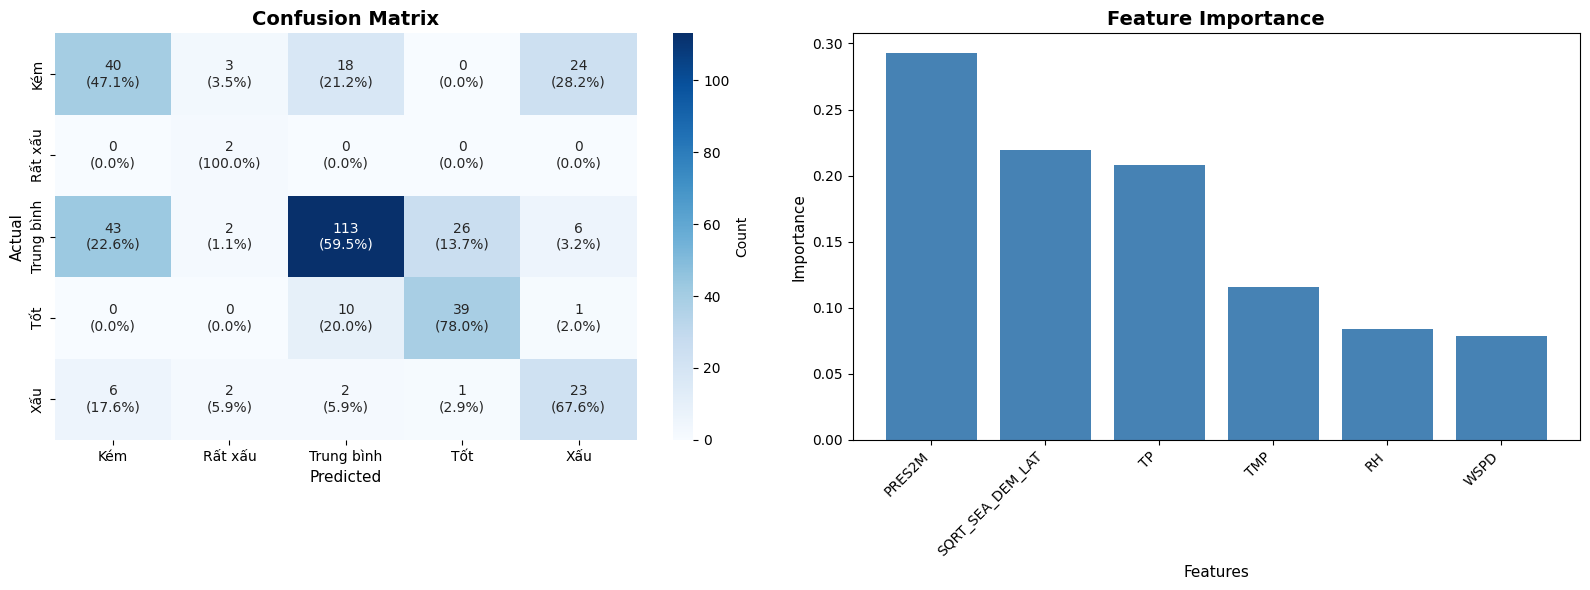


Feature Importance Ranking:
  1. PRES2M: 0.2930
  2. SQRT_SEA_DEM_LAT: 0.2197
  3. TP: 0.2082
  4. TMP: 0.1159
  5. RH: 0.0843
  6. WSPD: 0.0788


In [4]:
# =============================================================================
# CONFUSION MATRIX VÀ FEATURE IMPORTANCE
# =============================================================================

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

sns.heatmap(
    cm, annot=annot, fmt='', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names,
    cbar_kws={'label': 'Count'}, ax=ax1
)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted', fontsize=11)
ax1.set_ylabel('Actual', fontsize=11)

# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

ax2.bar(range(len(importances)), importances[indices], color='steelblue')
ax2.set_xticks(range(len(importances)))
ax2.set_xticklabels([feature_columns[i] for i in indices], rotation=45, ha='right')
ax2.set_xlabel('Features', fontsize=11)
ax2.set_ylabel('Importance', fontsize=11)
ax2.set_title('Feature Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for i, idx in enumerate(indices, 1):
    print(f"  {i}. {feature_columns[idx]}: {importances[idx]:.4f}")

In [5]:
# =============================================================================
# LƯU MODEL VÀ SO SÁNH VỚI NEURAL NETWORK
# =============================================================================

# Save model
joblib.dump(model, 'decision_tree_classifier.pkl')
joblib.dump(scaler, 'decision_tree_scaler.pkl')
joblib.dump(label_encoder, 'decision_tree_label_encoder.pkl')

print("✓ Model saved:")
print("  - decision_tree_classifier.pkl")
print("  - decision_tree_scaler.pkl")
print("  - decision_tree_label_encoder.pkl")

# So sánh với Neural Network
print("\n" + "="*80)
print("SO SÁNH DECISION TREE VS NEURAL NETWORK")
print("="*80)

print(f"\nDecision Tree Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Neural Network Accuracy: 0.5516 (55.16%)")
print(f"\n✓ Decision Tree tốt hơn {(accuracy - 0.5516)*100:.2f}%")

✓ Model saved:
  - decision_tree_classifier.pkl
  - decision_tree_scaler.pkl
  - decision_tree_label_encoder.pkl

SO SÁNH DECISION TREE VS NEURAL NETWORK

Decision Tree Accuracy: 0.6011 (60.11%)
Neural Network Accuracy: 0.5516 (55.16%)

✓ Decision Tree tốt hơn 4.95%


In [ ]:
# =============================================================================
# XỬ LÝ TIF VÀ TẠO BẢN ĐỒ AQI
# =============================================================================

def read_tif_file(filepath):
    """Đọc file TIF"""
    try:
        img = Image.open(filepath)
        data = np.array(img, dtype=np.float32)
        return data
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def find_available_dates(feature_maps_dir='../Feature_Maps-20251116T094941Z-1-001/Feature_Maps'):
    """Tìm các ngày có đầy đủ dữ liệu TIF"""
    required_features = ['PRES2M', 'RH', 'WSPD', 'TMP', 'TP']
    sample_feature_dir = f"{feature_maps_dir}/{required_features[0]}"
    
    if not os.path.exists(sample_feature_dir):
        print(f"❌ Directory not found: {sample_feature_dir}")
        return []
    
    tif_files = [f for f in os.listdir(sample_feature_dir) if f.endswith('.tif')]
    dates = [f.split('_')[1].replace('.tif', '') for f in tif_files]
    
    valid_dates = []
    for date in dates:
        all_exist = True
        for feature in required_features:
            feature_path = f"{feature_maps_dir}/{feature}/{feature}_{date}.tif"
            if not os.path.exists(feature_path):
                all_exist = False
                break
        if all_exist:
            valid_dates.append(date)
    
    valid_dates.sort()
    return valid_dates

def process_tif_to_predictions(model, scaler, label_encoder, date, feature_maps_dir='../Feature_Maps-20251116T094941Z-1-001/Feature_Maps'):
    """Xử lý TIF và tạo predictions cho một ngày"""
    
    print(f"\nProcessing date: {date}")
    
    # Load features
    features = {}
    feature_names = ['PRES2M', 'RH', 'WSPD', 'TMP', 'TP']
    
    for feature_name in feature_names:
        filepath = f"{feature_maps_dir}/{feature_name}/{feature_name}_{date}.tif"
        data = read_tif_file(filepath)
        if data is None:
            return None
        features[feature_name] = data
    
    # Load SQRT_SEA_DEM_LAT
    sqrt_path = f"{feature_maps_dir}/SQRT_SEA_DEM_LAT.tif"
    sqrt_data = read_tif_file(sqrt_path)
    
    # Prepare data
    shape = features['PRES2M'].shape
    rows, cols = shape
    total_pixels = rows * cols
    
    # Flatten
    flattened = {}
    for name, data in features.items():
        flattened[name] = data.flatten()
    
    if sqrt_data is not None:
        flattened['SQRT_SEA_DEM_LAT'] = sqrt_data.flatten()
    else:
        flattened['SQRT_SEA_DEM_LAT'] = np.full(total_pixels, 3.5)
    
    # Create DataFrame
    X_df = pd.DataFrame(flattened)
    
    # Valid mask
    valid_mask = np.ones(total_pixels, dtype=bool)
    for name in feature_names:
        valid_mask &= (flattened[name] != -9999)
    
    # Predict
    predictions = np.full(total_pixels, -1, dtype=np.int32)
    predictions_labels = np.full(total_pixels, 'NoData', dtype=object)
    
    X_valid = X_df[valid_mask].values
    if len(X_valid) > 0:
        X_scaled = scaler.transform(X_valid)
        y_pred = model.predict(X_scaled)
        y_pred_labels = label_encoder.inverse_transform(y_pred)
        
        predictions[valid_mask] = y_pred
        predictions_labels[valid_mask] = y_pred_labels
    
    # Create map
    predictions_2d = predictions.reshape(shape)
    
    colors = [
        '#FFFFFF',  # -1: NoData
        '#00E400',  # 0: Tốt
        '#FFFF00',  # 1: Trung bình
        '#FF7E00',  # 2: Kém
        '#FF0000',  # 3: Xấu
        '#8F3F97',  # 4: Rất xấu
    ]
    
    cmap = ListedColormap(colors)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(predictions_2d, cmap=cmap, vmin=-1, vmax=4, interpolation='nearest')
    
    cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1, 2, 3, 4])
    cbar.ax.set_yticklabels(['NoData', 'Tốt', 'Trung bình', 'Kém', 'Xấu', 'Rất xấu'])
    
    ax.set_title(f'Decision Tree - AQI Map {date}', fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save CSV
    os.makedirs('../output_csv_dt', exist_ok=True)
    csv_path = f'../output_csv_dt/TIF_Predictions_DT_{date}.csv'
    X_df['Predicted_AQI'] = predictions_labels
    X_df['Valid'] = valid_mask
    X_df.to_csv(csv_path, index=False)
    
    print(f"  ✓ CSV saved to {csv_path}")
    print(f"  Valid pixels: {valid_mask.sum():,}/{total_pixels:,}")
    
    return predictions_2d

# Tìm và xử lý các ngày
dates = find_available_dates()
print(f"\nFound {len(dates)} dates with complete data: {dates}")

for date in dates:
    process_tif_to_predictions(model, scaler, label_encoder, date)
    
print("\n" + "="*80)
print("✓ HOÀN THÀNH XỬ LÝ TẤT CẢ CÁC NGÀY")
print("="*80)

✓ Functions defined
